In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
print("ok")

ok


In [5]:
url="https://raw.githubusercontent.com/epfml/ML_course/master/labs/ex02/template/height_weight_genders.csv"
data=pd.read_csv(url)
print(data.head)

<bound method NDFrame.head of       Gender     Height      Weight
0       Male  73.847017  241.893563
1       Male  68.781904  162.310473
2       Male  74.110105  212.740856
3       Male  71.730978  220.042470
4       Male  69.881796  206.349801
5       Male  67.253016  152.212156
6       Male  68.785081  183.927889
7       Male  68.348516  167.971110
8       Male  67.018950  175.929440
9       Male  63.456494  156.399676
10      Male  71.195382  186.604926
11      Male  71.640805  213.741169
12      Male  64.766329  167.127461
13      Male  69.283070  189.446181
14      Male  69.243732  186.434168
15      Male  67.645620  172.186930
16      Male  72.418317  196.028506
17      Male  63.974326  172.883470
18      Male  69.640060  185.983958
19      Male  67.936005  182.426648
20      Male  67.915050  174.115929
21      Male  69.439440  197.731422
22      Male  66.149132  149.173566
23      Male  75.205974  228.761781
24      Male  67.893196  162.006652
25      Male  68.144033  192.34397

**Plots**

In [0]:

def prediction(w0, w1, mean_x, std_x):
    """Get the regression line from the model."""
    x = np.arange(-2, 2, 0.01)
    x_normalized = (x - mean_x) / std_x
    return x, w0 + w1 * x_normalized


def base_visualization(grid_losses, w0_list, w1_list,
                       mean_x, std_x, height, weight):
    """Base Visualization for both models."""
    w0, w1 = np.meshgrid(w0_list, w1_list)

    fig = plt.figure()

    # plot contourf
    ax1 = fig.add_subplot(1, 2, 1)
    cp = ax1.contourf(w0, w1, grid_losses.T, cmap=plt.cm.jet)
    fig.colorbar(cp, ax=ax1)
    ax1.set_xlabel(r'$w_0$')
    ax1.set_ylabel(r'$w_1$')
    # put a marker at the minimum
    loss_star, w0_star, w1_star = get_best_parameters(
        w0_list, w1_list, grid_losses)
    ax1.plot(w0_star, w1_star, marker='*', color='r', markersize=20)

    # plot f(x)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(height, weight, marker=".", color='b', s=5)
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.grid()

    return fig


def grid_visualization(grid_losses, w0_list, w1_list,
                       mean_x, std_x, height, weight):
    """Visualize how the trained model looks like under the grid search."""
    fig = base_visualization(
        grid_losses, w0_list, w1_list, mean_x, std_x, height, weight)

    loss_star, w0_star, w1_star = get_best_parameters(
        w0_list, w1_list, grid_losses)
    # plot prediciton
    x, f = prediction(w0_star, w1_star, mean_x, std_x)
    ax2 = fig.get_axes()[2]
    ax2.plot(x, f, 'r')

    return fig


def gradient_descent_visualization(
        gradient_losses, gradient_ws,
        grid_losses, grid_w0, grid_w1,
        mean_x, std_x, height, weight, n_iter=None):
    """Visualize how the loss value changes until n_iter."""
    fig = base_visualization(
        grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)

    ws_to_be_plotted = np.stack(gradient_ws)
    if n_iter is not None:
        ws_to_be_plotted = ws_to_be_plotted[:n_iter]

    ax1, ax2 = fig.get_axes()[0], fig.get_axes()[2]
    ax1.plot(
        ws_to_be_plotted[:, 0], ws_to_be_plotted[:, 1],
        marker='o', color='w', markersize=10)
    pred_x, pred_y = prediction(
        ws_to_be_plotted[-1, 0], ws_to_be_plotted[-1, 1],
        mean_x, std_x)
    ax2.plot(pred_x, pred_y, 'r')

    return fig

**Some helper functions**

In [0]:
def load_data(data,sub_sample=True, add_outlier=False):
    """Load data and convert it to the metric system."""
   
    height = data[:, 0]
    weight = data[:, 1]
   
    # Convert to metric system
    height *= 0.025
    weight *= 0.454

    # sub-sample
    if sub_sample:
        height = height[::50]
        weight = weight[::50]

    if add_outlier:
        # outlier experiment
        height = np.concatenate([height, [1.1, 1.2]])
        weight = np.concatenate([weight, [51.5/0.454, 55.3/0.454]])

    return height, weight

def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x, mean_x, std_x


def build_model_data(height, weight):
    """Form (y,tX) to get regression data in matrix form."""
    y = weight
    x = height
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    return y, tx


def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

**1: Computing cost function**

In [0]:
def compute_loss(y, tx, w):
    """Calculate the loss.
    You can calculate the loss using mse or mae.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    ## for mse
    e=y-tx.dot(w)
    loss=(1/2)*np.mean(e**2)
    #for mae np.mean(np.abs(e))
    
    return loss
                    

    
    # TODO: compute loss by MSE / MAE
    # ***************************************************
    

**2: Grid Search**

In [0]:
def generate_w(num_intervals): 
    # num interval same for wo and w1, so we have squares
    """Generate a grid of values for w0 and w1."""
    w0 = np.linspace(-100, 200, num_intervals)
    w1 = np.linspace(-150, 150, num_intervals)
    return w0, w1


def get_best_parameters(w0, w1, losses):
    """Get the best w from the result of grid search."""
    min_row, min_col = np.unravel_index(np.argmin(losses), losses.shape)
    return losses[min_row, min_col], w0[min_row], w1[min_col]


# ***************************************************
# INSERT YOUR CODE HERE
# TODO: Paste your implementation of grid_search
#       here when it is done.
# ***************************************************

def grid_search(y,tx,w0,w1):
    #w0 is a list of param0
    losses=np.zeros((len(w0),len(w1)))
    for i0,param0 in enumerate(w0):
        loss=np.array([])
        for i1,param1 in enumerate(w1):
            loss=np.append(loss,compute_loss(y,tx,np.array([param0,param1])))
        losses[i0,:]=loss
    return losses
    

0.0 1.5151515151515014
0.24669614974975243


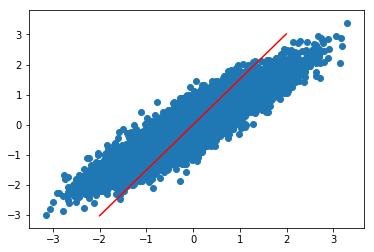

In [59]:

height=(data.iloc[:,1]-np.mean(data.iloc[:,1]))/np.std(data.iloc[:,1])

weight=(data.iloc[:,2]-np.mean(data.iloc[:,2]))/np.std(data.iloc[:,2])
#normalized

y,tx=build_model_data(height,weight)
w0,w1=generate_w(100)
loss,w0Grid,w1Grid=get_best_parameters(w0,w1,grid_search(y,tx,w0,w1))
print(w0Grid,w1Grid)
print(loss)

x,y_predict=prediction(w0Grid,w1Grid,0,1)

plt.plot(x,y_predict,color="red")
plt.scatter(height,weight)



**3: Gradient Descent**

In [0]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    # ***************************************************
    #tx is already transposed
    e=y-tx.dot(w)
    gradient=np.array([-1*np.mean(e),(-1/len(e))*(e.dot(tx[:,1]))])
    
    #gradient = -tx.T.dot(e) / len(e)
    
    return gradient
    
    # INSERT YOUR CODE HERE
    # TODO: compute gradient and loss
    # ***************************************************
    #raise NotImplementedError


def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = np.array([initial_w])
    losses = np.empty([])
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        # ***************************************************
        loss=compute_loss(y,tx,w)
        losses=np.append(losses,loss)
        w=w-gamma*compute_gradient(y,tx,w)
       # ws=np.concatenate((ws,w))
        #raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        #raise NotImplementedError
        # store w and loss
    
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, w

Gradient Descent(0/999): loss=0.41767059088138797, w0=0.7919999999999997, w1=0.7022475629874088
Gradient Descent(1/999): loss=0.4107999627128408, w0=0.7840799999999993, w1=0.7044726503449434
Gradient Descent(2/999): loss=0.4040660600448481, w0=0.776239199999999, w1=0.7066754868289028
Gradient Descent(3/999): loss=0.3974661620399496, w0=0.7684768079999987, w1=0.7088562949480226
Gradient Descent(4/999): loss=0.39099760200534833, w0=0.7607920399199984, w1=0.7110152949859512
Gradient Descent(5/999): loss=0.38465776631543486, w0=0.7531841195207981, w1=0.7131527050235005
Gradient Descent(6/999): loss=0.37844409335574974, w0=0.7456522783255898, w1=0.7152687409606743
Gradient Descent(7/999): loss=0.37235407248796437, w0=0.7381957555423335, w1=0.7173636165384764
Gradient Descent(8/999): loss=0.36638524303544767, w0=0.7308137979869098, w1=0.7194375433605004
Gradient Descent(9/999): loss=0.36053519328903444, w0=0.7235056600070404, w1=0.7214907309143042
Gradient Descent(10/999): loss=0.35480155953

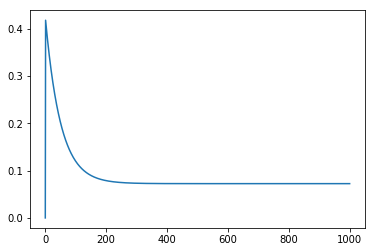

In [128]:
n=1000
n_x=np.linspace(0,n,n+1)
losses,w=gradient_descent(y,tx,np.array([0.8,0.7]),n,0.01)
plt.plot(n_x,losses)

[3.45369979e-05 9.24746596e-01]


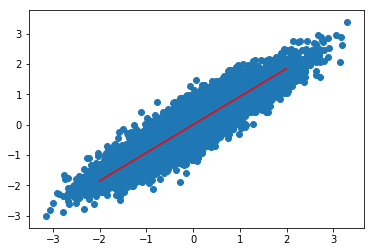

In [117]:
print(w)
w0GD=w[0]
w1GD=w[1]
x,y_predict=prediction(w0GD,w1GD,0,1)

plt.plot(x,y_predict,color="red")
plt.scatter(height,weight)



**Stochastic Gradient Descent**

In [0]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation.It's same as the gradient descent.
    e=y-tx.dot(w)
    gradient=np.array([-1*np.mean(e),(-1/len(e))*(e.dot(tx[:,1]))])
    
    #gradient = -tx.T.dot(e) / len(e)
    
    return gradient
      
    
    #raise NotImplementedError


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient descent.
    # ***************************************************
    #raise NotImplementedError
    ws=[initial_w]
    w=initial_w
    losses=[]
    for n_iter in range(max_iters):
      for mini_batch_y,mini_batch_x in batch_iter(y,tx,batch_size):
        w=w-gamma*compute_stoch_gradient(mini_batch_y,mini_batch_x,w)
        ws.append(w)
        loss=compute_loss(mini_batch_y,mini_batch_x,w)
        losses.append(loss)
        print("SGD:({bi}/{ti}): loss={l}, w0={w0},w1={w0}".format(bi=n_iter,ti=max_iters,l=loss,w0=w[0],w1=w[1]))
   
  
      
      
    return losses, ws

SGD:(0/5000): loss=0.465485145397405, w0=0.7991324488132606,w1=0.7991324488132606
SGD:(1/5000): loss=0.4774169301766997, w0=0.7982319666849197,w1=0.7982319666849197
SGD:(2/5000): loss=0.40942557589981166, w0=0.7974428640555374,w1=0.7974428640555374
SGD:(3/5000): loss=0.347825198118795, w0=0.7966827490500122,w1=0.7966827490500122
SGD:(4/5000): loss=0.30106336150563157, w0=0.7960102012248781,w1=0.7960102012248781
SGD:(5/5000): loss=0.41424737715369975, w0=0.7952303835827675,w1=0.7952303835827675
SGD:(6/5000): loss=0.2880814436769402, w0=0.794546165414359,w1=0.794546165414359
SGD:(7/5000): loss=0.31610473025455166, w0=0.7938150233865698,w1=0.7938150233865698
SGD:(8/5000): loss=0.2552143400679986, w0=0.7932452276764232,w1=0.7932452276764232
SGD:(9/5000): loss=0.413006647991427, w0=0.7923992879378274,w1=0.7923992879378274
SGD:(10/5000): loss=0.3170104861664214, w0=0.7917362941205605,w1=0.7917362941205605
SGD:(11/5000): loss=0.4291920720485604, w0=0.7909097746494073,w1=0.7909097746494073
SGD

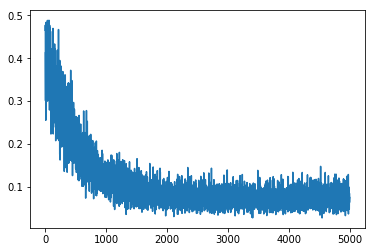

In [129]:
n=5000
n_x=np.linspace(1,n,n)
batch_size=32
losses,w=stochastic_gradient_descent(y,tx,np.array([0.8,0.7]),batch_size,n,0.001)
plt.plot(n_x,losses)

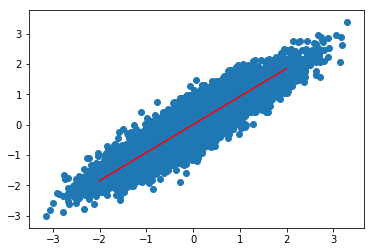

In [130]:
w0SGD=w[-1][0]
w1SGD=w[-1][1]
x,y_predict=prediction(w0SGD,w1SGD,0,1)

plt.plot(x,y_predict,color="red")
plt.scatter(height,weight)


**Subgradient Descent**